#  Dutch Restaurant reviews

Predict the score using the review texts from reviews scrapes already some time ago from the iens.nl website. 

In [1]:
### set up things
import datatable as dt
import pandas as pd
import seaborn as sns
from langdetect import detect

import re 

from sklearn.feature_extraction.text import CountVectorizer

import spacy
nlp = spacy.load("nl_core_news_sm")

sns.set(rc={'figure.figsize':(10,6)})

### Import data 

In [27]:
# All reviews are in a zipped csv file, but this file was too big to share on github. 
# So I splitted the file into two chunks with the command line tool split. 
# These two parts, restaurantaa and restaurantab, need to be put together first.

!cat restauranta* > all_reviews.zip

In [ ]:
### I am using the fread function in datatable to import zipped CSV text file
iens = dt.fread('all_reviews.zip')
iens.shape

In [22]:
### show some rows
iens.tail(5)

,reviewer,RestaurantNaam,Review,keuken,datum,eten,service,decor,ID
,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪
0,marian_groot,Het Ei Van Columbus,Heerlijk gegeten! Vooraf een heerlijke proeverij w…,FRANS,23/06/2013,8,9,8,211136
1,Kremers,Het Ei Van Columbus,Vanwege verjaardag van Oma uit eten. Keuzemenu bes…,FRANS,15/06/2013,8,8,7,211137
2,Mark-Gerards,Het Ei Van Columbus,Wij hebben hier met 6 personen gegeten en het is o…,FRANS,29/12/2012,10,10,1,211138
3,posth151,Het Ei Van Columbus,De bediening was zonder meer vriendelijk en gastvr…,FRANS,28/12/2012,7,8,6,211139
4,CulinairOegstgeest,Het Ei Van Columbus,Lekker gegeten in dit restaurant op mooie lokatie …,FRANS,09/11/2012,7,7,7,211140


In [6]:
### show one review in full length
iens[3,2]

"Wat moet je hier nu weer mee?Goede cijfers op de Iens app, maar al schrijvende komt er weer een proest van humoristische verbazing boven. Dit is een leuke poging tot restaurant, met niet goed opgeleid personeel dat wel heel erg haar best doet en een maaltijd die ternauwernood volstaat voor de prijs.Matias zit aan een drukke straat met heel veel restaurantjes, de proppers staan voor de deur. Dit was onze 2e keus, maar we moesten te lang wachten bij onze 1e keus voor spareribs en cocktails. Toen wij aankwamen, na een hele leuke dag Rijksmuseum, zaten er uitsluitend toeristen binnen. De groep Amerikaanse jongeren waren over de korting aan het bakkeleien, waarmee blijkbaar geadverteerd werd buiten.Dit restaurantje is niet groot, een tafel op 10. Het personeel telde 6 tot 8 mensen, zo telde ik snel. Er was niet veel te doen, dus hingen ze een beetje rond. Wel heel vriendelijk overigens.De maaltijden zijn Mexicaans, met was Oosterse invloeden. Margarita's zijn goed, verhoudingsgewijs duur. 

In [29]:
reviews = iens.to_pandas()

#### Language detection

We focus on Dutch reviews only. Use the `langdetect`package to detect the language of all reviews. This will take some time to process all 211K reviews

In [47]:
reviews["language"] = reviews.Review.apply(detect)

In [48]:
reviews.language.value_counts()

nl    210340
af       501
en       288
de         3
so         2
no         2
sl         1
it         1
ca         1
da         1
Name: language, dtype: int64

In [49]:
reviews.to_pickle("reviews.pck")

In [52]:
### take only Dutch reviews with non missing 'eten' (food) score
reviews_NL = (
    reviews
    .query('language =="nl"')
    .dropna(subset=['eten', 'Review'])
)

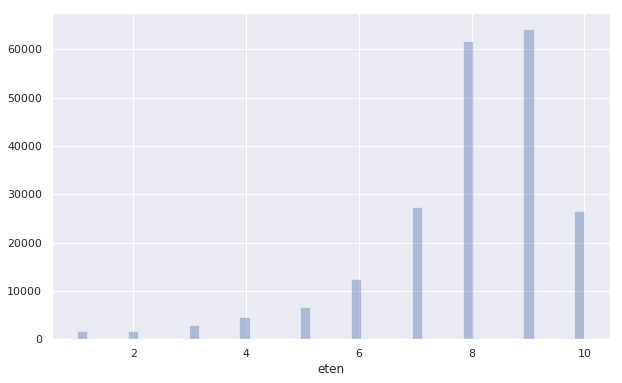

In [53]:
### Overview of the score given
sns.distplot(reviews_NL.eten, kde = False)

In [58]:
### example reviews with bad score
pd.options.display.max_colwidth = 1000
reviews_NL.query('eten < 4').sample(5)[["Review", "eten"]]

,Review,eten
32684,"De bediening kun je het beste omschrijven als verwarde kippen in een meer dan chaotisch kippenhok.Het geserveerde eten was lauw, kleine porties en weinig inspirerend.Heel vervelend ook dat de serveerster uitsluitend Engels sprak.Entourage: mooi, industrieel, maar ook erg koud.Na afloop onze magen pas echt goed gevuld in de kroeg, met bittergarnituur ( 3 x )",1.0
202023,"09-08-2014 dinner bij de trein in Valkenburg bij aankomst terras vrijwel leeg. Koude tomatensoep , het eten werd in een sneltrein vaart gebracht soep net naar binnen en serveerster kwam al met het hoofdgerecht tja de kok is snel vandaag , in de tussentijd waren ze het terras aan het opruimen ( tafels en stoelen naar binnen ) in mijn ooghoeken zie ik dat de serveerster een bod van de tafel pakt en op de grond plaatst voor hun hond (ieeuw) bij onze menu's gaven we aan dat we graag saté saus erbij wilde ( varkenshaas ) ow sorry foutje van de keuken ze zouden meteen brengen klein schaaltje saté saus die later 7,50 extra bleek te kosten salade die bij de 4 menu's hoorde werd in een klein schaaltje gedaan net genoeg voor 1 persoon het vlees was niet gaar ( vandaar de snelle levertijd of we op wilde schieten en alvast wilde aangeven of we koffie of ijs nawilde want de keuken gaat zo dicht ....? Iedereen snel het eten naar binnen werken snel naar het vieze toilet , geen wc papier aanwezig...",1.0
145716,"""gisteren met 2 vrienden een 3 gangen schnitzel menu gegeten hier, tenminste dat hebben geprobeerd maar we zijn niet verder dan het hoofdgerecht gekomen. het gaat al mis als je wilt reserveren, je kan met je grouponbon voor 4 personen alleen voor 2 personen reserveren, een andere keuze is er niet in het systeem. als je daarna probeert contact op te nemen via mail of telefoon krijg je geen respons. Dus bij aankomst al direct een \p""robleem\"" want er was maar voor 2 personen gereserveerd. Dit werd dan toch vrij simpel opgelost door ons met 4 personen aan een 2 persoonstafeltje te proppen, en dit terwijl de zaak bijna half leeg was (en bleef). we werden direct gevraagd of we iets wilde drinken en na deze bestelling bleef het lang stil......na ongeveer 30 minuten werden de colaatjes gebracht waarna het toch weer zeker 20 minuten duurde voor men onze bestelling voor het eten kwam opnemen. Ondertussen hebben wij vrij zicht op de keuken waar het helemaal vol stond met borden die moesten w...",2.0
122491,"""Nimmer zulk slecht voedsel gegeten. We hadden een Menu Express, waarbij je uitsluitend van één bepaald buffet mocht pakken, plus het saladebuffet.Alle vlees- en visgerechten (de zalm bij het saladebuffet uitgezonderd) waren zo doorgekookt en doorgebakken dat kauwen niet hoefde, het was meer slurpen. Geen kraak of smaak aan deze gerechten. Rijst- en bamigerechten waren nog wel te eten, maar op het saladebuffet lag veel, maar alles wat je aan smaak mag verwachten, bleef uit. Tomaten: waterig en geen smaak. Asperges: flauwe smaak, zeker geen aspergesmaak. Mais: droog en geen smaak. De koks van Onderweg zouden echt een bijscholingscursus moeten gaan volgen, \H""oe bereid ik smakelijke- en voedzame gerechten\"". Als klap op de vuurpijl zat er, op de dag waarop het kwik over de 30 graden was, zelfs aan mijn niet gekoelde appelsap een onbestemde smaak. Op de bon stond \""Flevosap\"". Dit drink ik bijna dagelijks vanuit de supermarkt, maar de heerlijke smaak daarvan wordt in de verste verte n...",3.0
52188,"""Voor wie lekker wil eten is Bergers niet de beste plek. Jammer. De voorgerechten waren veel te groot en weinig spannend van smaak. Het hoofdgerecht ging echt nergens over - dat kan ik thuis beter - de zalm was overladen met een bak roomkaas, \w""aar is de zalm\""?!. Het zag er niet aantrekkelijk uit en de smaak was ook niet om over naar huis te schrijven. Bediening is vriendelijk en accuraat. Ondanks het slechte eten toch een heel gezellige avond gehad met vrienden.""",3.0


### Preparing text for further analysis

In [2]:
reviews_nl = pd.read_pickle("reviews.pck")

In [12]:
reviews_nl.iloc[3,2]

"Wat moet je hier nu weer mee?Goede cijfers op de Iens app, maar al schrijvende komt er weer een proest van humoristische verbazing boven. Dit is een leuke poging tot restaurant, met niet goed opgeleid personeel dat wel heel erg haar best doet en een maaltijd die ternauwernood volstaat voor de prijs.Matias zit aan een drukke straat met heel veel restaurantjes, de proppers staan voor de deur. Dit was onze 2e keus, maar we moesten te lang wachten bij onze 1e keus voor spareribs en cocktails. Toen wij aankwamen, na een hele leuke dag Rijksmuseum, zaten er uitsluitend toeristen binnen. De groep Amerikaanse jongeren waren over de korting aan het bakkeleien, waarmee blijkbaar geadverteerd werd buiten.Dit restaurantje is niet groot, een tafel op 10. Het personeel telde 6 tot 8 mensen, zo telde ik snel. Er was niet veel te doen, dus hingen ze een beetje rond. Wel heel vriendelijk overigens.De maaltijden zijn Mexicaans, met was Oosterse invloeden. Margarita's zijn goed, verhoudingsgewijs duur. 

In [24]:
### get the number of words per review
reviews_nl = (
    reviews_nl
    .assign(
        n_words = reviews_nl.Review.apply(lambda x : len(re.findall(r'\w+', x)))
    )
)

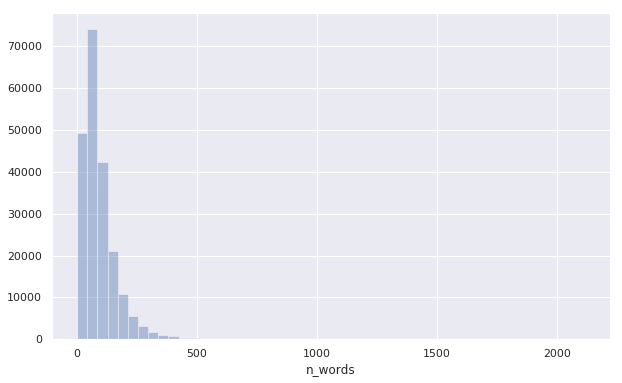

In [27]:
sns.distplot(reviews_nl.n_words, kde=False)

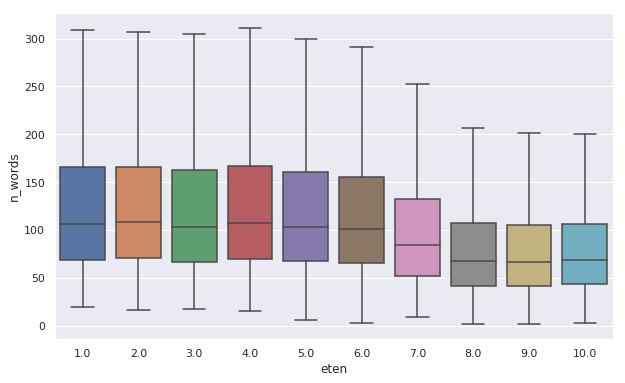

In [42]:
sns.boxplot(y = "n_words", x = "eten", data = reviews_nl, showfliers=False)

seems that people who give lower scores ( eten <7) tend to use more words to write the review

In [3]:
nlp.Defaults.stop_words

{'aan',
 'af',
 'al',
 'alles',
 'als',
 'altijd',
 'andere',
 'ben',
 'bij',
 'daar',
 'dan',
 'dat',
 'de',
 'der',
 'deze',
 'die',
 'dit',
 'doch',
 'doen',
 'door',
 'dus',
 'een',
 'eens',
 'en',
 'er',
 'ge',
 'geen',
 'geweest',
 'haar',
 'had',
 'heb',
 'hebben',
 'heeft',
 'hem',
 'het',
 'hier',
 'hij',
 'hoe',
 'hun',
 'iemand',
 'iets',
 'ik',
 'in',
 'is',
 'ja',
 'je',
 'kan',
 'kon',
 'kunnen',
 'maar',
 'me',
 'meer',
 'men',
 'met',
 'mij',
 'mijn',
 'moet',
 'na',
 'naar',
 'niet',
 'niets',
 'nog',
 'nu',
 'of',
 'om',
 'omdat',
 'ons',
 'ook',
 'op',
 'over',
 'reeds',
 'te',
 'tegen',
 'toch',
 'toen',
 'tot',
 'u',
 'uit',
 'uw',
 'van',
 'veel',
 'voor',
 'want',
 'waren',
 'was',
 'wat',
 'we',
 'wel',
 'werd',
 'wezen',
 'wie',
 'wij',
 'wil',
 'worden',
 'zal',
 'ze',
 'zei',
 'zelf',
 'zich',
 'zij',
 'zijn',
 'zo',
 'zonder',
 'zou'}

In [12]:
doc = nlp(reviews_nl.iloc[3,2])
tokens = [token.text for token in doc if (not token.is_punct) & (not token.is_stop)]
tokens

['Wat',
 'weer',
 'mee?Goede',
 'cijfers',
 'Iens',
 'app',
 'schrijvende',
 'komt',
 'weer',
 'proest',
 'humoristische',
 'verbazing',
 'boven',
 'Dit',
 'leuke',
 'poging',
 'restaurant',
 'goed',
 'opgeleid',
 'personeel',
 'heel',
 'erg',
 'best',
 'doet',
 'maaltijd',
 'ternauwernood',
 'volstaat',
 'prijs',
 'Matias',
 'zit',
 'drukke',
 'straat',
 'heel',
 'restaurantjes',
 'proppers',
 'staan',
 'deur',
 'Dit',
 'onze',
 '2e',
 'keus',
 'moesten',
 'lang',
 'wachten',
 'onze',
 '1e',
 'keus',
 'spareribs',
 'cocktails',
 'Toen',
 'aankwamen',
 'hele',
 'leuke',
 'dag',
 'Rijksmuseum',
 'zaten',
 'uitsluitend',
 'toeristen',
 'binnen',
 'De',
 'groep',
 'Amerikaanse',
 'jongeren',
 'korting',
 'bakkeleien',
 'waarmee',
 'blijkbaar',
 'geadverteerd',
 'buiten',
 'Dit',
 'restaurantje',
 'groot',
 'tafel',
 '10',
 'Het',
 'personeel',
 'telde',
 '6',
 '8',
 'mensen',
 'telde',
 'snel',
 'Er',
 'hingen',
 'beetje',
 'rond',
 'Wel',
 'heel',
 'vriendelijk',
 'overigens',
 'De',
 'm